In [1]:
%pip install -q scikit-learn scipy seaborn torchvision pandas matplotlib opencv-python torchcam

Note: you may need to restart the kernel to use updated packages.


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr  2 21:49:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:27:00.0 Off |                  N/A |
| 32%   53C    P0             62W /  250W |       0MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from collections import defaultdict
import cv2 as cv
import math
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
import os
import pandas as pd
import random
# import seaborn as sns
from scipy import stats
from scipy import interpolate
from scipy import optimize
from scipy.ndimage import zoom, rotate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import ast 

import sys
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import warnings

warnings.filterwarnings('ignore')
random_seed = 43

/tmp/ipykernel_549124/1331004422.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# !unzip /content/drive/MyDrive/Thesis/anesthetized_stims.zip -d /content/drive/MyDrive/Thesis/

In [5]:
# slices_fig_size = (30,8)
# active_indices_threshold =98

In [6]:
meta_data_dir = data_dir = './../../data/processed_anesth_registered_response_4th_offset/'
# "/user/l.mysurukrishnamur/data/processed_data/response_onset_4/all"

dt_codes=['220423']#, '220424', '220425', '220426', '220427', '220428', '220429', '220430']


In [7]:
active_indices = tuple(
    np.load('./../../data/thresholded_offset_4_active_indices_percentile_99.npy'))
    # np.load('../data/processed_data/response_onset_4/220426/active_indices_percentile_98.npy'))
zero_respones = np.zeros_like(np.load(data_dir+'/responses/10.npy'))[active_indices]
output_shape = zero_respones.shape[0]


# stim_dir = data_dir+'/images'
response_dir = data_dir+'/responses'

# # Create a list of file names in your data directory
file_list = os.listdir(response_dir)
resp = np.array([np.load(response_dir + '/' + fname) for fname in file_list])

In [8]:
active_indices

(array([ 0,  1,  1, ..., 31, 31, 31]),
 array([35,  8,  8, ..., 18, 18, 18]),
 array([49, 22, 23, ..., 46, 47, 48]))

In [9]:
# zero_respones.shape

In [10]:
np.load(data_dir+'/responses/10.npy').shape#[6:36,12:46,20:60].shape

(40, 57, 66)

In [11]:

multiplied_val = 1e2
multiplied_val

100.0

In [12]:

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [13]:
stratified_maps = pd.read_csv(meta_data_dir + '/metadata/img_ids.csv')
stratified_maps['img_file'] = stratified_maps['stim_id'].astype(str)+'.npy'
image_dict = stratified_maps[['img_file', 'img_id']].set_index('img_file').to_dict()['img_id']

In [14]:
stratified_maps['img_pattern'] = 'natural_image'
stratified_maps.loc[stratified_maps.stim_type.str.lower().str.contains('texture'), 'img_pattern'] = 'texture'
stratified_maps

,stimArray,img_id,stim_id,stim_type,img_file,img_pattern
0,stims/Mouse9.npy,35,0,Mice,0.npy,natural_image
1,stims/Mouse7.npy,33,1,Mice,1.npy,natural_image
2,stims/Mouse8.npy,34,2,Mice,2.npy,natural_image
3,stims/Mouse11.npy,26,3,Mice,3.npy,natural_image
4,stims/Mouse6.npy,32,4,Mice,4.npy,natural_image
...,...,...,...,...,...,...
763,stims/textureScramble_Bird2.npy,16,763,Birds_texture,763.npy,texture
764,stims/textureScramble_Bird5.npy,19,764,Birds_texture,764.npy,texture
765,stims/textureScramble_Bird7.npy,21,765,Birds_texture,765.npy,texture
766,stims/textureScramble_Bird12.npy,15,766,Birds_texture,766.npy,texture


In [15]:
# stratified_maps.is_texture.value_counts()



In [16]:
target = pd.get_dummies(stratified_maps.img_pattern, dtype=float)
# y = target.to_numpy()

In [17]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(target)
y = ohe.transform(target)
# # print(y.shape)

In [18]:
stratified_maps['y'] = [(y) for y in target.to_numpy()]

In [19]:
# stratified_maps
stratified_maps

,stimArray,img_id,stim_id,stim_type,img_file,img_pattern,y
0,stims/Mouse9.npy,35,0,Mice,0.npy,natural_image,"[1.0, 0.0]"
1,stims/Mouse7.npy,33,1,Mice,1.npy,natural_image,"[1.0, 0.0]"
2,stims/Mouse8.npy,34,2,Mice,2.npy,natural_image,"[1.0, 0.0]"
3,stims/Mouse11.npy,26,3,Mice,3.npy,natural_image,"[1.0, 0.0]"
4,stims/Mouse6.npy,32,4,Mice,4.npy,natural_image,"[1.0, 0.0]"
...,...,...,...,...,...,...,...
763,stims/textureScramble_Bird2.npy,16,763,Birds_texture,763.npy,texture,"[0.0, 1.0]"
764,stims/textureScramble_Bird5.npy,19,764,Birds_texture,764.npy,texture,"[0.0, 1.0]"
765,stims/textureScramble_Bird7.npy,21,765,Birds_texture,765.npy,texture,"[0.0, 1.0]"
766,stims/textureScramble_Bird12.npy,15,766,Birds_texture,766.npy,texture,"[0.0, 1.0]"


In [20]:
stratified_maps.img_pattern.value_counts()



img_pattern
natural_image    384
texture          384
Name: count, dtype: int64

In [21]:

group_dict = defaultdict(list)
for img, group in image_dict.items():
    group_dict[group].append(img)

In [22]:
# Separate keys (image names) and values (image IDs) from the dictionary
groups = list(group_dict.keys())

# Use train_test_split with the 'stratify' parameter
train_files, other_files = train_test_split(stratified_maps.img_file.to_list(),
                    test_size=0.2, random_state=random_seed
)

val_files, test_files = train_test_split(
    other_files, test_size=0.5, random_state=random_seed
)

print(f'train file size: {len(train_files)}, val file size: {len(val_files)}, test file size: {len(test_files)}')

train file size: 614, val file size: 77, test file size: 77


In [23]:
train_group = [np.array(stratified_maps.loc[stratified_maps.img_file==file_name, 'y'].values[0]).astype(float) for file_name in train_files]
val_group = [np.array(stratified_maps.loc[stratified_maps.img_file==file_name, 'y'].values[0]).astype(float) for file_name in val_files]
test_group = [np.array(stratified_maps.loc[stratified_maps.img_file==file_name, 'y'].values[0]).astype(float) for file_name in test_files]

In [24]:
# train_files

class responseDecoderDataset(Dataset):
    def __init__(self,  response_dir, files, target_group, transform=None, train=True):
        # self.data_dir = stim_dir
        self.response_dir = response_dir
        self.file_list = files #os.listdir(data_dir)
        self.target_group = np.array(target_group)
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        response_file_path = os.path.join(self.response_dir, file_name)

        #input_image = np.load(data_file_path)  # Load the numpy array as an image
        response_array = np.load(response_file_path) * multiplied_val
        response_array = response_array[active_indices].flatten()
        if self.transform:
            response_array = self.transform(response_array)

            
        labels = torch.tensor(self.target_group[idx], dtype=torch.float)
        return torch.tensor(response_array).float(), labels


In [25]:

transform = transforms.Compose([transforms.ToTensor()])

# Create datasets and dataloaders for train, validation, and test sets
train_dataset = responseDecoderDataset(response_dir, train_files, train_group)
val_dataset = responseDecoderDataset(response_dir, val_files, val_group)
test_dataset = responseDecoderDataset(response_dir, test_files, test_group)

In [26]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalClassifier(nn.Module):
    def __init__(self, input_length, num_windows, output_dim):
        super(ConvolutionalClassifier, self).__init__()
        # Calculate the kernel size and stride needed to get 'num_windows' from 'input_length'
        self.stride = input_length // num_windows
        self.kernel_size = input_length - (num_windows - 1) * self.stride
        # Define the convolutional layer
        self.conv0 = nn.Conv1d(in_channels=1, out_channels=1, 
                               kernel_size=1, stride=1)

        # Define the convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, 
                               kernel_size=self.kernel_size, stride=self.stride)
        
        # Define the output layer
        self.fc = nn.Linear(num_windows, output_dim)

    def forward(self, x):
        # Add an extra dimension for the single channel (batch_size, channels, length)
        x = x.unsqueeze(1)
        
        # Apply the convolution
        x = self.conv0(x)
        x = F.relu(self.conv1(x))
        
        # Remove the extra dimension and apply the fully connected layer
        x = x.squeeze(1)
        x = self.fc(x)
        
        return x

# Assuming the input tensor shape is [batch_size, sequence_length]
batch_size = 16
sequence_length = 1505
num_windows = 1450
output_dim = 2  # For binary classification

# Create the model
model = ConvolutionalClassifier(input_length=sequence_length, 
                                num_windows=num_windows, 
                                output_dim=output_dim).to(device)

print(model)


ConvolutionalClassifier(
  (conv0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
  (conv1): Conv1d(1, 1, kernel_size=(56,), stride=(1,))
  (fc): Linear(in_features=1450, out_features=2, bias=True)
)


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming train_dataloader and val_dataloader are PyTorch DataLoader instances
# Define the loss criterion and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using the Adam optimizer

num_epochs = 15  # Number of epochs to train for

train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0

    # Training loop
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

        running_train_loss += train_loss.item()

        # Convert outputs probabilities to predicted class (0 or 1)
        preds = torch.round(torch.sigmoid(outputs))
        correct_train_preds += (preds == labels).float().sum().item()
        total_train_preds += labels.size(0)

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_accuracy = correct_train_preds / total_train_preds/2

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():  # No need to track gradients for validation
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()

            # Convert outputs probabilities to predicted class (0 or 1)
            preds = torch.round(torch.sigmoid(outputs))
            correct_val_preds += (preds == labels).float().sum().item()
            total_val_preds += labels.size(0)

    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_accuracy = correct_val_preds / total_val_preds /2

    # After calculating the accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print training and validation loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/15, Training Loss: 0.6702, Training Accuracy: 0.5969, Validation Loss: 0.6399, Validation Accuracy: 0.6364
Epoch 2/15, Training Loss: 0.5424, Training Accuracy: 0.7476, Validation Loss: 0.5720, Validation Accuracy: 0.6558
Epoch 3/15, Training Loss: 0.4290, Training Accuracy: 0.8151, Validation Loss: 0.5174, Validation Accuracy: 0.7338
Epoch 4/15, Training Loss: 0.3446, Training Accuracy: 0.8550, Validation Loss: 0.4872, Validation Accuracy: 0.7078
Epoch 5/15, Training Loss: 0.2886, Training Accuracy: 0.8901, Validation Loss: 0.4777, Validation Accuracy: 0.7208
Epoch 6/15, Training Loss: 0.2011, Training Accuracy: 0.9381, Validation Loss: 0.4070, Validation Accuracy: 0.7987
Epoch 7/15, Training Loss: 0.1542, Training Accuracy: 0.9511, Validation Loss: 0.3567, Validation Accuracy: 0.8571
Epoch 8/15, Training Loss: 0.1099, Training Accuracy: 0.9756, Validation Loss: 0.3956, Validation Accuracy: 0.8052
Epoch 9/15, Training Loss: 0.0716, Training Accuracy: 0.9943, Validation Loss: 0

In [29]:

preds = []
actual = []
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data
    actual.append(labels.numpy())
    inputs = inputs.unsqueeze(1)
    with torch.no_grad():
        output = model(inputs.to(device).squeeze(1).squeeze(1))
        output = torch.sigmoid(output).cpu().numpy().squeeze()
        preds.append(output)


In [30]:
# Calculate the confusion matrix and ROC curve for the model's predictions
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

In [31]:

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

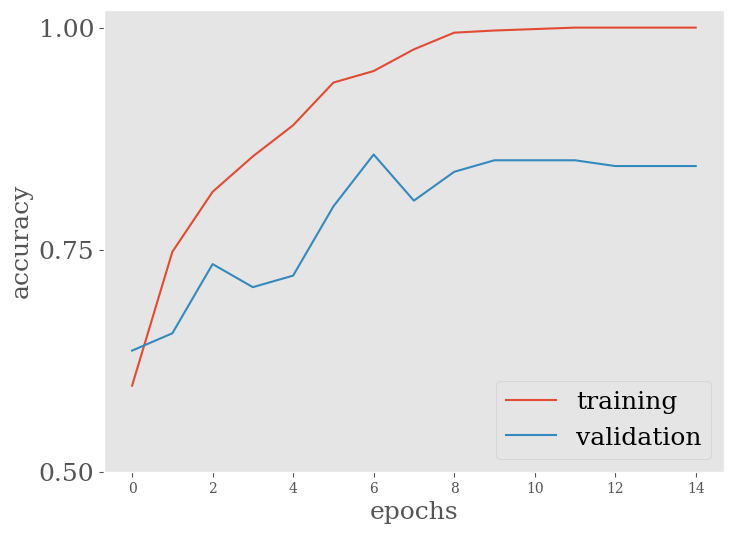

In [32]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the accuracies
ax.plot(train_accuracies, label='training')
ax.plot(val_accuracies, label='validation')

plt.xlabel('epochs', {'fontsize':18})
plt.ylabel('accuracy', {'fontsize':18})

plt.yticks([0.5, 0.75,1], fontsize=18)
ax.grid(False)
# Add a legend
ax.legend(fontsize=18)

plt.savefig("Accuracy.png")
# Show the plot
plt.show()

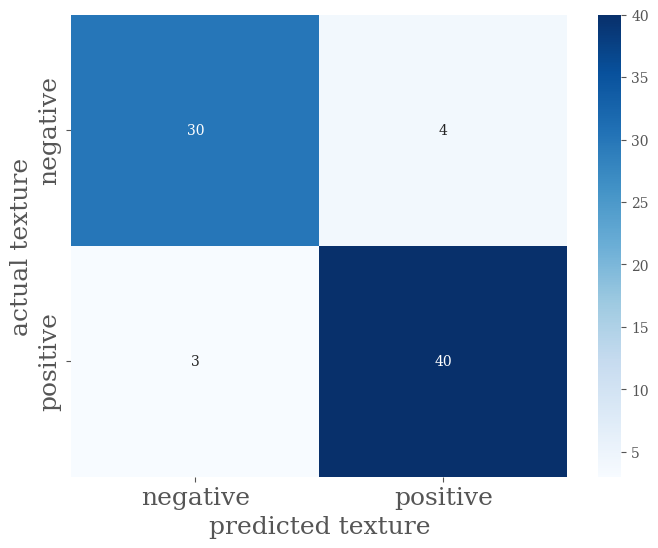

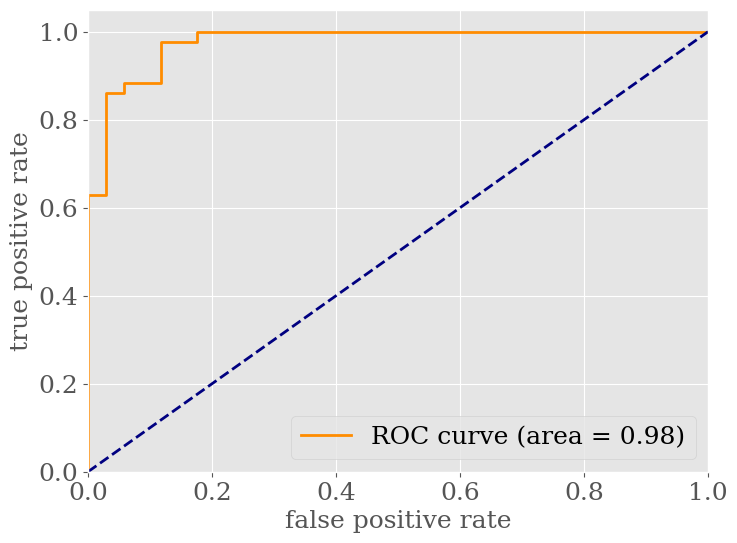

In [33]:


# Assuming actual and preds are lists of numpy arrays with actual labels and predicted probabilities
# Flatten the lists of numpy arrays to create a single array for actual and predicted values
actual_flat = np.array(actual).squeeze()[:,1]
preds_flat = np.array(preds).squeeze()[:,1]

# Apply threshold to predicted probabilities to convert them to binary classification
threshold = 0.5
preds_labels = (preds_flat > threshold).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(actual_flat, preds_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'], annot_kws={"fontsize":10})
# plt.title('Confusion Matrix')
plt.ylabel('actual texture',{'fontsize':18})
plt.xlabel('predicted texture', {'fontsize':18})
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.savefig("Confusion_matrix")
plt.show()

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(actual_flat, preds_flat)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('false positive rate', {'fontsize':18})
plt.ylabel('true positive rate', {'fontsize':18})
plt.legend(loc="lower right", fontsize=18)


plt.savefig("ROC")
plt.show()


In [34]:
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

#

In [35]:

preds = []
actual = []
test_dataloader = DataLoader(test_dataset, batch_size=len(test_files), shuffle=True)

for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data
    actual.append(labels.numpy())
    inputs = inputs.unsqueeze(1)
    with torch.no_grad():
        output = model(inputs.to(device).squeeze(1).squeeze(1))
        output = torch.sigmoid(output).cpu().numpy().squeeze()
        preds.append(output)


In [36]:

input_tensor = inputs.to(device)
logits = model(inputs.to(device).squeeze(1).squeeze(1))

# Get the predicted class indices
_, predicted_classes = logits.max(dim=1)

# Instantiate your CAM extractor
# Make sure to specify the correct layer name for the target_layer parameter
cam_extractor = GradCAM(model, target_layer='conv0')

# You need to perform the forward pass again with the specific input for which you want the CAM
# This is because the hooks need to capture the feature maps during the forward pass
# Here, we use the first image in the batch as an example
target_input = input_tensor[0].unsqueeze(0)  # Add batch dimension
target_logits = model(inputs.to(device).squeeze(1).squeeze(1))



In [37]:
texture_indices = np.where(predicted_classes.cpu().numpy()==1)
natural_image_indices = np.where(predicted_classes.cpu().numpy()==0)

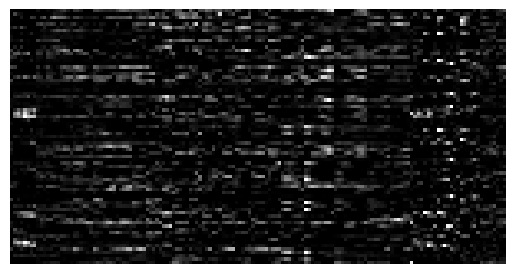

In [38]:
# Generate the CAM for the highest scoring class of the target input
target_predicted_class = predicted_classes#[0].unsqueeze(0)  # Get the predicted class for the target input
cams = cam_extractor(target_predicted_class.tolist(), target_logits)

# Assuming 'input_tensor' is normalized, denormalize it if necessary
# input_tensor = denormalize(input_tensor)  # Implement this function based on your normalization

# We'll just use the first image in the batch for visualization
input_image = to_pil_image(target_input)

# Get the CAM for the first image and the predicted class
cam = cams[0].cpu()


plt.imshow(to_pil_image(cam[:,:150], mode='L'), cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

In [39]:
explaination = np.zeros_like(np.load(data_dir+'/responses/10.npy'))
n_explaination = np.zeros_like(np.load(data_dir+'/responses/10.npy'))
explaination.shape

(40, 57, 66)

In [40]:
explaination[active_indices] = cam[texture_indices].mean(axis=0)
n_explaination[active_indices] = cam[natural_image_indices].mean(axis=0)

In [41]:
def get_stacked_slices(data, apply_filter=False, kernel=None):
    I_proc = np.zeros((40,3762))
    for j in range(data.shape[2]):
        I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = data[:,:,j]
        if apply_filter:
            I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = cv.filter2D(data[:,:,j],-1,kernel)

    I_proc = I_proc[:, (34*57)-1:(-11*57)-1]
    crop_len = int(I_proc.shape[1]/3)
    arrays = [I_proc[:,i*crop_len:(i+1)*crop_len] for i in range(3)]
    I_proc=np.vstack(arrays)
    return I_proc

In [42]:
kernel = np.ones((1,2),np.float32)
texture_explaination_slices = get_stacked_slices(explaination, True, kernel)
natural_explaination_slices = get_stacked_slices(n_explaination, True, kernel)

In [56]:
def plot_slices_heatmap(slices_1, cmap, axs, alpha=0.5):
    cax1 = axs.imshow(slices_1, cmap=cmap, alpha=alpha)
    cax1.set_clim(-0.25, 0.25)
    

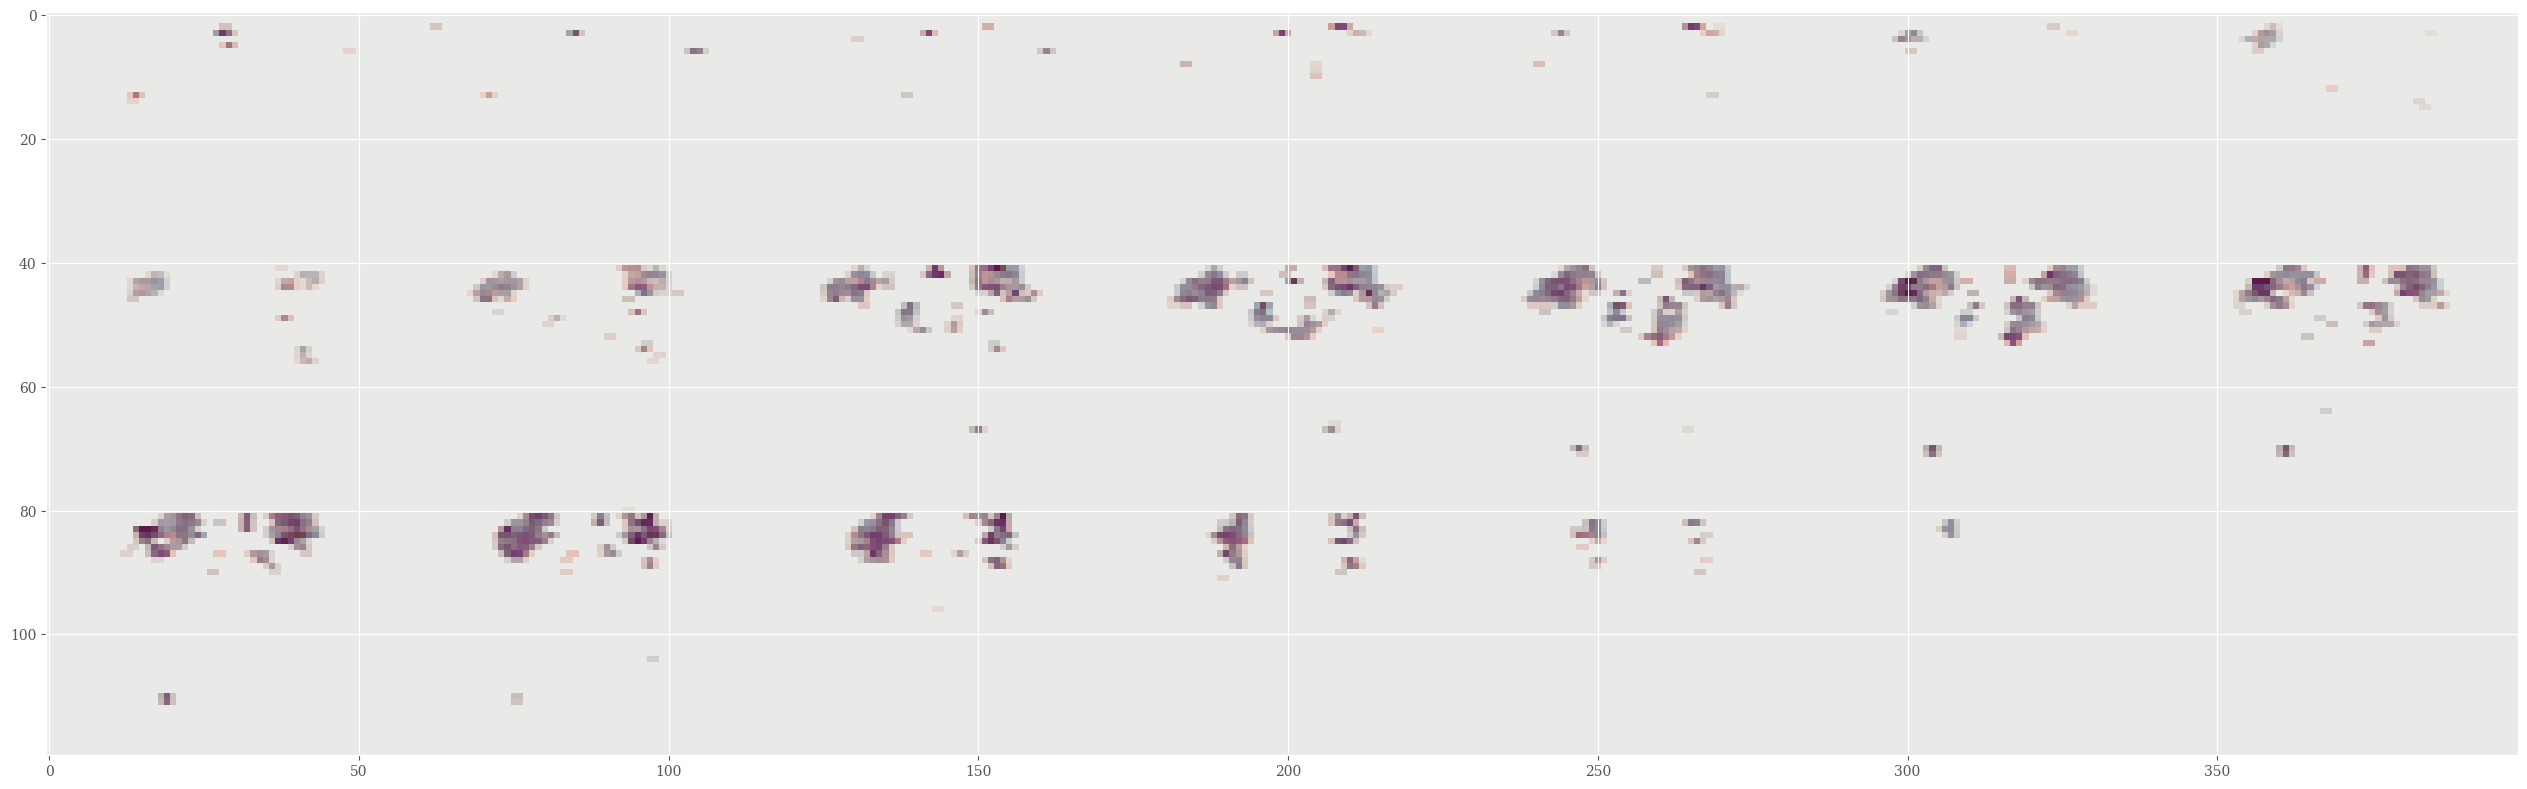

In [57]:
fig, axs = plt.subplots(1, 1, figsize = [30,8])
plot_slices_heatmap(texture_explaination_slices, 'RdBu', axs, 1)
plot_slices_heatmap(natural_explaination_slices, 'coolwarm', axs, 0.5)
fig.tight_layout()
plt.show()

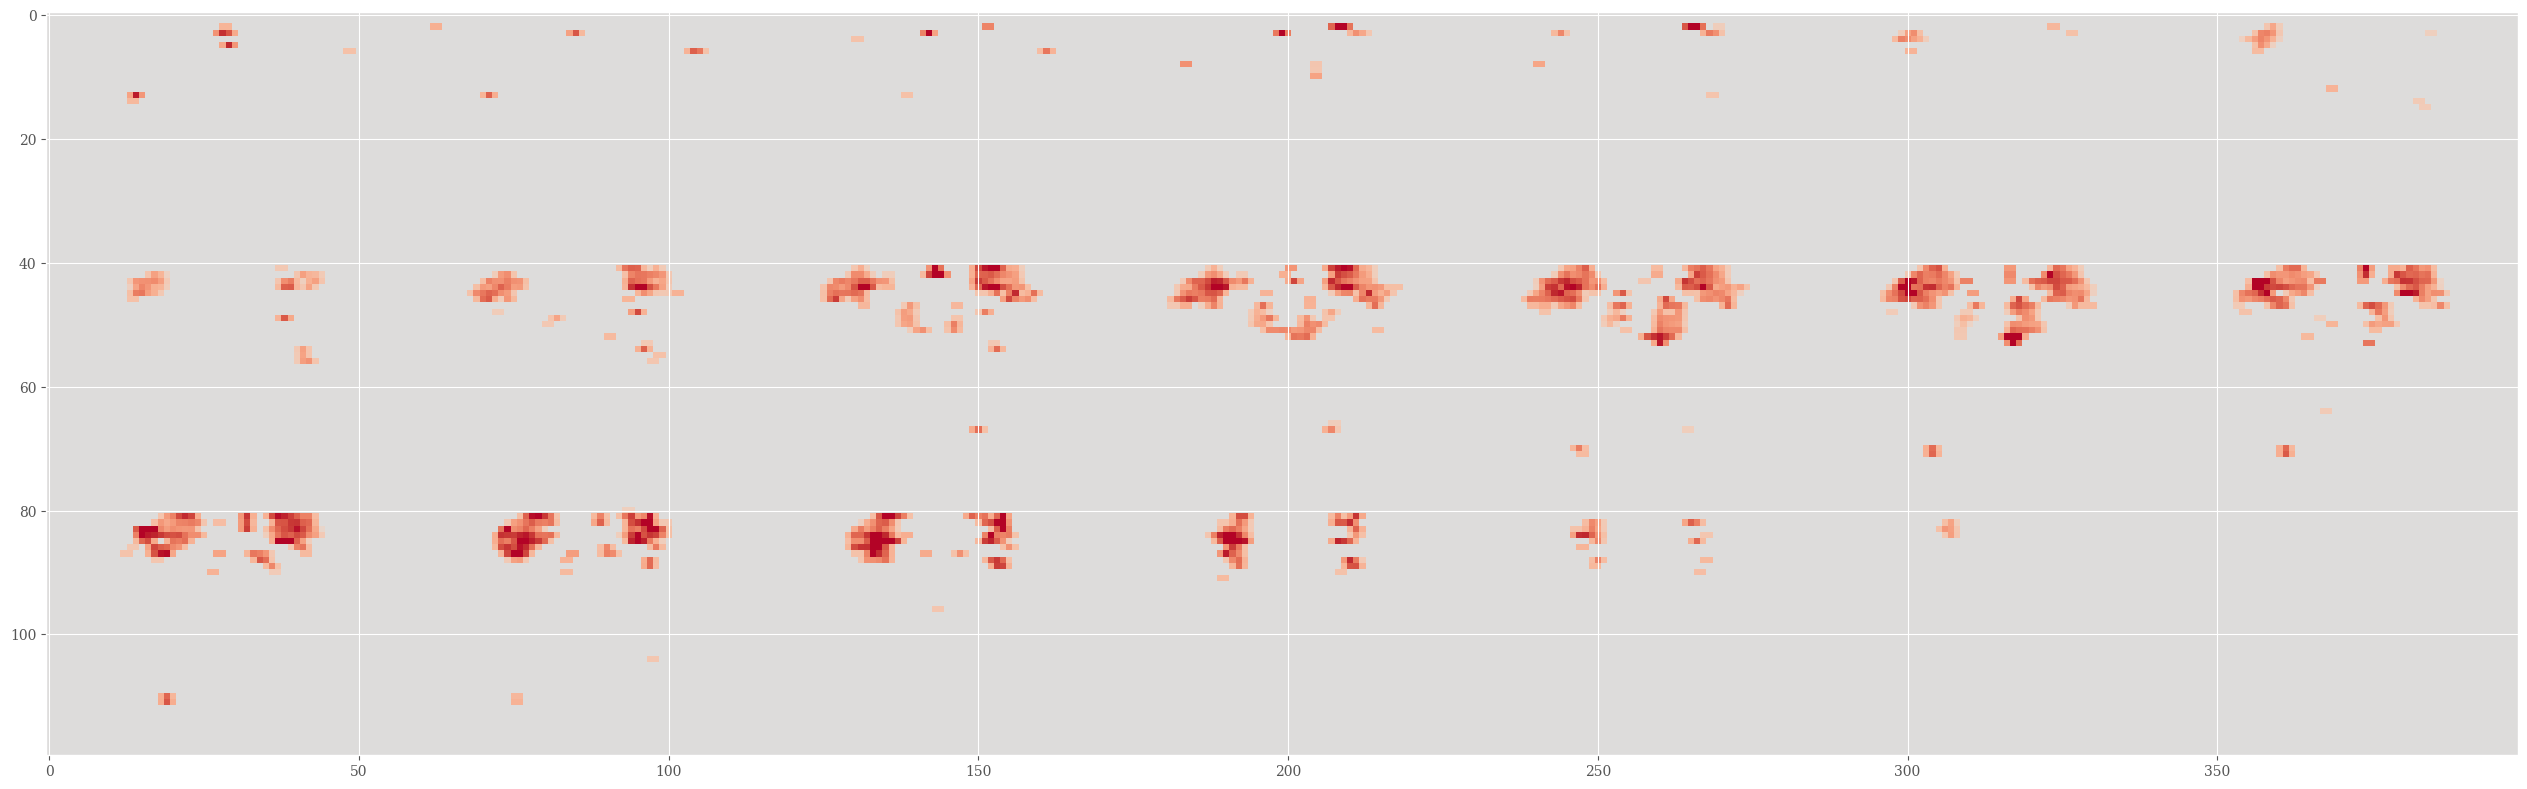

In [61]:
fig, axs = plt.subplots(1, 1, figsize = [30,8])
plot_slices_heatmap(natural_explaination_slices, 'coolwarm', axs, 1)

fig.tight_layout()
plt.show()

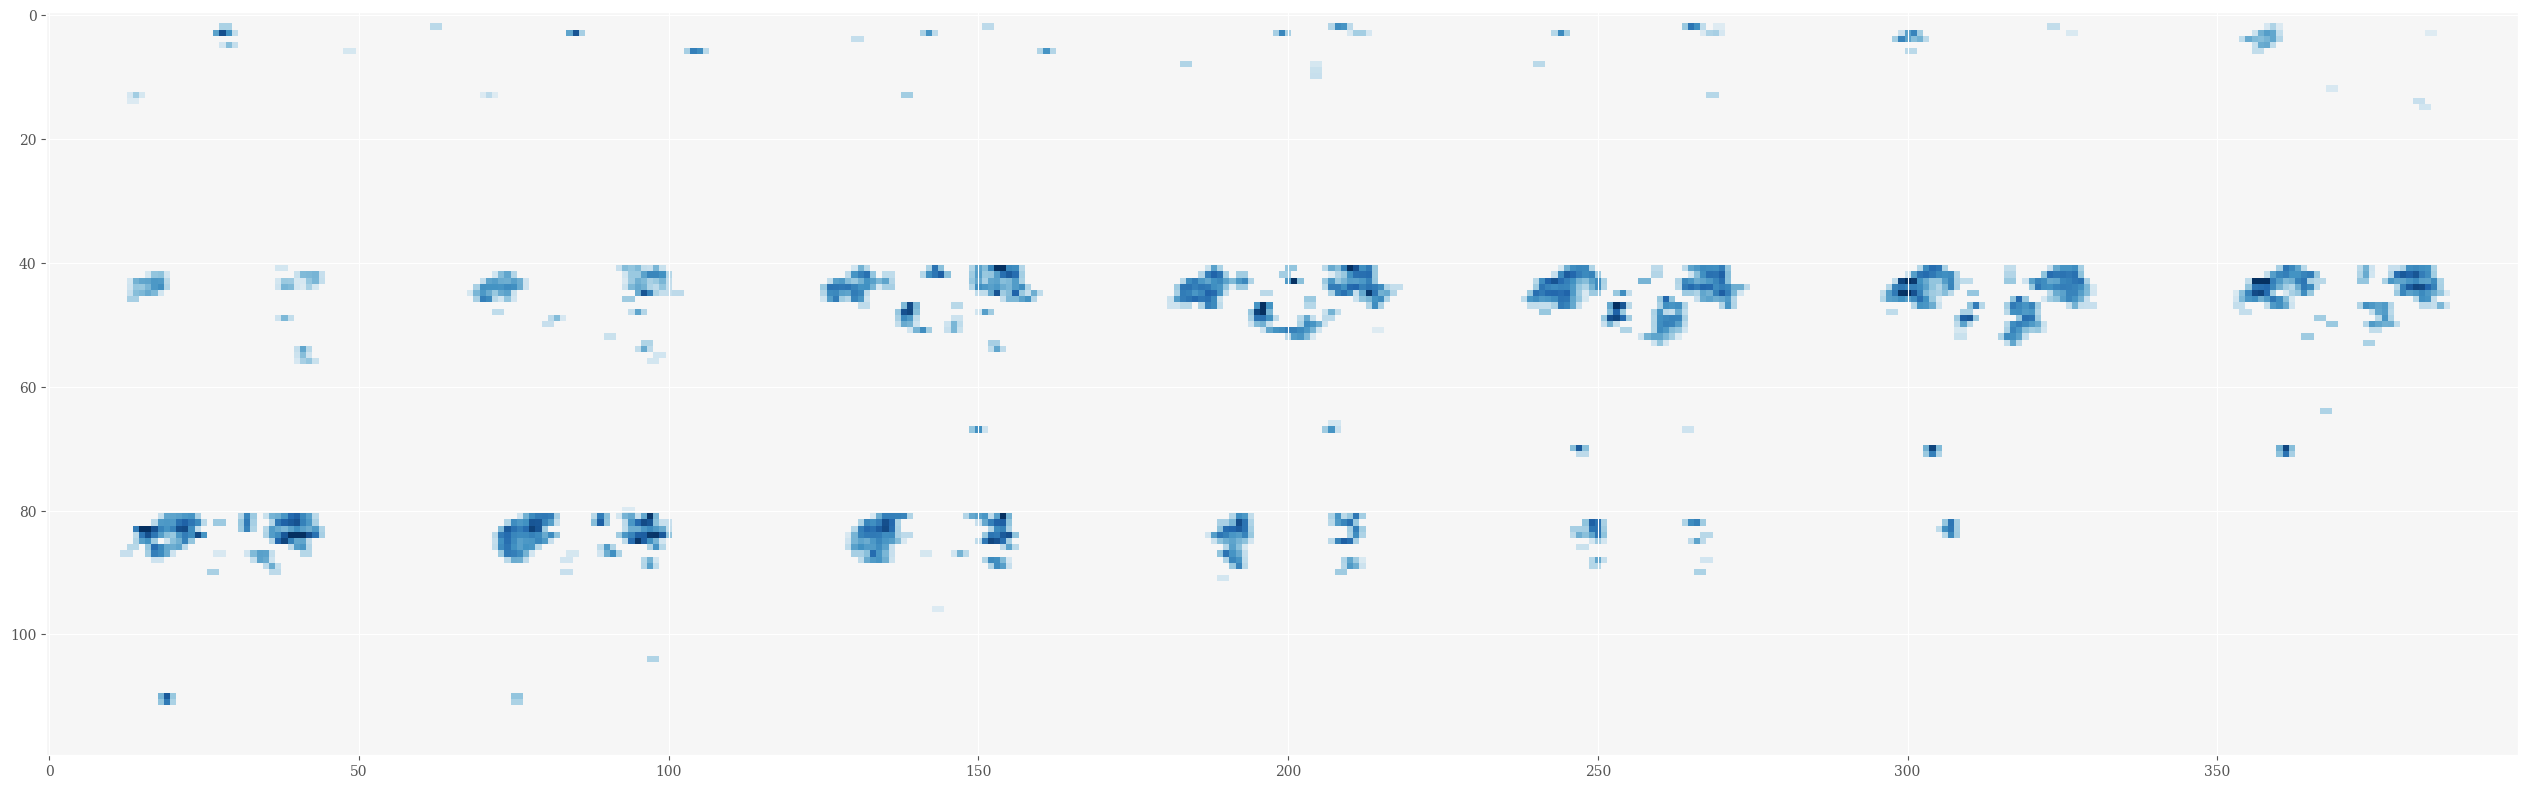

In [62]:
fig, axs = plt.subplots(1, 1, figsize = [30,8])
plot_slices_heatmap(texture_explaination_slices, 'RdBu', axs, 1)
fig.tight_layout()
plt.show()

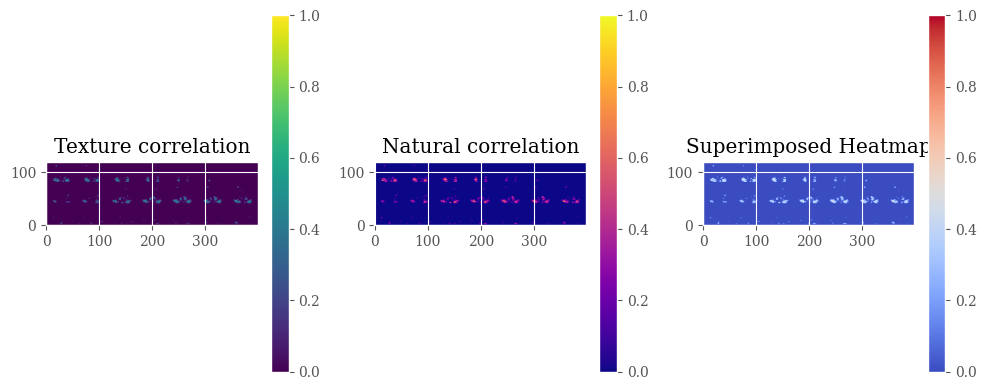

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data to [0, 1] for better visualization
heatmap1 = texture_explaination_slices / np.max(texture_explaination_slices)
heatmap2 = natural_explaination_slices / np.max(natural_explaination_slices)

# Create a weighted overlay by averaging the two heatmaps
alpha = 0.5  # Weight for overlay (adjust as needed)
composite_heatmap = alpha * heatmap1 + (1 - alpha) * heatmap2

# Plot the original heatmaps
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(heatmap1, cmap='viridis', origin='lower')
plt.title('Texture correlation')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(heatmap2, cmap='plasma', origin='lower')
plt.title('Natural correlation')
plt.colorbar()

# Plot the weighted overlay heatmap
plt.subplot(1, 3, 3)
plt.imshow(composite_heatmap, cmap='coolwarm', origin='lower')
plt.title('Superimposed Heatmap')
plt.colorbar()

plt.tight_layout()
plt.show()
